In [311]:
import scipy
import numpy as np
from scipy.linalg import cholesky, cho_solve

import matplotlib
import matplotlib.pyplot as plt

In [315]:
def exponentiated_quadratic(xa, xb, length_scale=1):
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

n = 50
num_f = 10

X = np.expand_dims(np.linspace(-4, 4, n), 1)
# Kernel based on the datapoints
sigma = exponentiated_quadratic(X, X)

# Sample the prior at X
y = np.random.multivariate_normal(mean=np.zeros(n), cov=sigma, size=num_f)

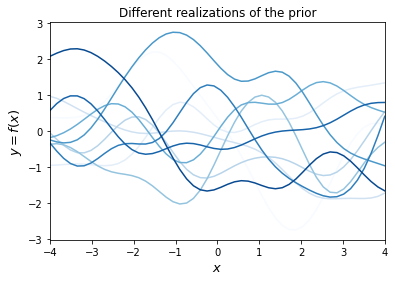

In [316]:
plt.figure(figsize=(6, 4))
cmap = matplotlib.colormaps.get_cmap('Blues')
colors = [cmap(i/num_f) for i in range(num_f)]

for i in range(num_f):
    plt.plot(X, y[i], linestyle='-', color=colors[i])
    
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title('Different realizations of the prior')
plt.xlim([-4, 4])
plt.show()

f_star-2*var_f_starThe algorithm as defined in 'Gaussian Processes for Machine Learning':

$$
\begin{array}{l}
\textbf{Gaussian Process} \\
\textbf{input: } X \text{ (inputs)}, y \text{ (targets)}, k \text{ (covariance function)}, \sigma_n^2 \text{ (noise level)}, x_* \text{ (test input)} \\
\quad L := \text{cholesky}(K + \sigma_n^2 I) \\
\quad \alpha := L^T \backslash (L \backslash y) \\
\quad f_* := k_*^T \alpha \quad \textit{(predictive mean)} \\
\quad v := L \backslash k_* \\
\quad \mathbb{V}[f_*] := k(x_*, x_*) - v^T v \quad \textit{(predictive variance)} \\
\quad \log p(y | X) := -\frac{1}{2} y^T \alpha - \sum_i \log L_{ii} - \frac{n}{2} \log 2\pi \\
\quad \textbf{return } f_*, \mathbb{V}[f_*], \log p(y | X) \text{ (log marginal likelihood)}
\end{array}
$$

In [317]:
f_sin = lambda x: (np.sin(x)).flatten()

n = 8
n_ = 75
domain = (-6, 6)

# Sample training samples (X1, y1)
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n, 1))
y1 = f_sin(X1)

# Test samples
X2 = np.linspace(domain[0], domain[1], n_).reshape(-1, 1)

In [318]:
class GaussianProcess:
    def __init__(self, kernel, noise_sigma: float = 0.0, length_scale: float = 1.0):
        self.kernel = kernel
        self.noise_sigma = noise_sigma
        self.length_scale = length_scale # TODO: Use it
    
    def fit(self, X, y):
        # Store the training points
        self.X = X
        
        K = self.kernel(X, X) + (self.noise_sigma ** 2) * np.eye(X.shape[0])
        self.L = cholesky(K, lower=True)
        self.alpha = cho_solve((self.L, True), y)
    
    def predict(self, X_):
        k_star = self.kernel(X_, self.X)
        f_mean = k_star.dot(self.alpha) # Mean

        v = cho_solve((self.L, True), k_star.T)
        f_cov = self.kernel(X_, X_) - k_star.dot(v) # Covariance
        return f_mean, f_cov
    
    
GP = GaussianProcess(kernel=exponentiated_quadratic)

GP.fit(X1, y1)
mean, cov = GP.predict(X2)

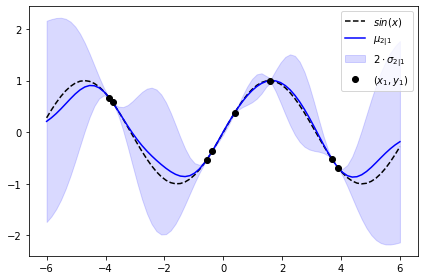

In [319]:
def plot_fit(mean, cov, X, y, f_true, X_):
    var = np.sqrt(np.diag(cov))
    
    plt.plot(X_, f_true(X_), 'k--', label='$sin(x)$')
    plt.plot(X_[:, 0], mean, color='b', label='$\mu_{2|1}$')
    plt.fill_between(X_[:, 0], mean-2*var, mean+2*var,
        color='b', alpha=0.15, label='$2 \cdot \sigma_{2|1}$')
    
    plt.plot(X, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
    plt.legend()
    plt.tight_layout()
    
plot_fit(mean, cov, X=X1, y=y1, X_=X2, f_true=f_sin)

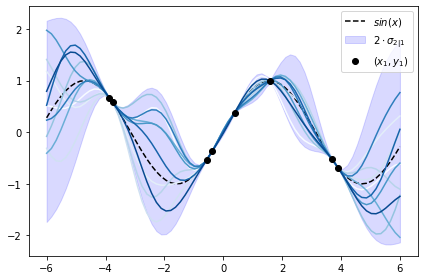

In [320]:
# Number of functions to sample from the posterior
num_f = 10
y_pred = np.random.multivariate_normal(mean, cov, size=num_f)

def plot_posterior(mean, cov, X, y, f_true, X_):
    var = np.sqrt(np.diag(cov))
    
    plt.plot(X_, f_true(X_), 'k--', label='$sin(x)$')
    plt.fill_between(X_[:, 0].flat, mean-2*var, mean+2*var,
        color='b', alpha=0.15, label='$2 \cdot \sigma_{2|1}$')
    
    for i in range(y_pred.shape[0]):
        plt.plot(X_, y_pred[i].T, color=colors[i])

    plt.plot(X, y, 'ko', linewidth=2, label='$(x_1, y_1)$')
    plt.legend()
    plt.tight_layout()
    

plot_posterior(mean, cov, X1, y1, f_sin, X2)

How much difference is there between using the cholesky decomposition versus naive matrix inversion?

The difference starts to show whenever I greatly increase the samples, in the range of thousands.

In [321]:
f_sin = lambda x: (np.sin(x)).flatten()

n = 1600
n_ = 1500
domain = (-1000, 1000)

# Sample training samples (X1, y1)
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n, 1))
y1 = f_sin(X1)

# Test samples
X2 = np.linspace(domain[0], domain[1], n_).reshape(-1, 1)

In [ ]:
%%timeit
GP.fit(X1, y1)
mean, cov = GP.predict(X2)

In [ ]:
def naive_inversion_fit(X, y, X_, kernel, noise_sigma = 0.0):
    K = kernel(X, X) + (noise_sigma ** 2) * np.eye(X.shape[0])    
    K_inv = np.linalg.inv(K)
    
    mean = kernel(X_, X) @ K_inv @ y
    cov  = kernel(X_, X_) - (kernel(X_, X) @ K_inv @ kernel(X, X_))
    return mean, cov

In [ ]:
%%timeit
mean, cov = naive_inversion_fit(X1, y1, X2, kernel=exponentiated_quadratic)